# Vegetation Condition Index estimation from multispectral imagery using Pix2Pix
> * 🔬 Data Science
> * 🥠 Deep Learning and image translation

## Table of Contents

* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Export image domain data](#Export-image-domain-data)
* [Methodology](#Methodology)
* [Model training](#Model-training)
  * [Prepare data](#Prepare-data)
  * [Load model architecture](#Load-model-architecture)
  * [Tuning for optimal learning rate](#Tuning-for-optimal-learning-rate)
  * [Fit the model](#Fit-the-model)
  * [Visualize results in validation set](#Visualize-results-in-validation-set)
  * [Save the model](#Save-the-model)
  * [Compute evaluation metrics](#Compute-evaluation-metrics)
* [Model inferencing](#Model-inferencing)
* [Results visualization](#1)
* [Conclusion](#Conclusion)

## Introduction 

The Vegetation Condition Index (VCI) can be used for vegetation stress early detection, enabling timely responses to factors like drought and pest infestations. It serves as a key tool in monitoring agricultural productivity, aiding farmers in optimizing crop management practices. VCI is essential for environmental conservation, helping assess and protect natural habitats. Additionally, it contributes valuable data to climate change studies by indicating how ecosystems respond to changing environmental conditions.

Traditionally, VCI from Landsat is calculated using a chain of formulas that are complex and demanding of resources. Fortunately, deep learning models provide an efficient way to compute and predict VCI. In this study, we propose an approach to predicting VCI from Landsat 5 & 8 imagery using the [Pix2PixHD](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#pix2pixhd) deep learning model. The VCI will be computed for both Landsat 5 & Landsat 8 using Normalized Difference Vegetation Index (NDVI). The calculated VCI will then be used to train an image translation Pix2Pix model. The model will then be capable of translating Landsat-5 & Landsat-8 multispectral imagery to VCI, allowing the predictions to be used for multitemporal monitoring of VCI.

## Necessary imports

In [1]:
import os
from pathlib import Path

from arcgis import GIS
from arcgis.learn import Pix2PixHD, prepare_data

 ## Connect to your GIS

In [2]:
gis = GIS('home')

## Export image domain data

A stacked raster of Landsat-8 bands has been created using bands 1-7 and band 10. This mosaic will be used as our `input_raster` for the training data.

<Item title:"landsat_composite" type:Imagery Layer owner:demos_deldev>
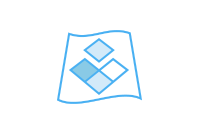

In [3]:
landsat_mosaic = gis.content.get('952468e0942c4b6893006cb267cbf040')
landsat_mosaic

The raster for Land Surface Temperature is generated using the thermal band (band 10). This raster will be used as the `Additional Input Raster` for the training data.

<Item title:"LST_raster" type:Imagery Layer owner:demos_deldev>
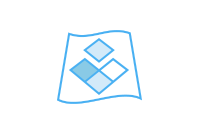

In [4]:
lst_raster = gis.content.get('ad29f8ab93354e77bcb22ba83f9a846a')
lst_raster

## Methodology

Vegetation Condition Index (VCI) compares the current NDVI to range of values observed in the same period in previous years.

                            VCI = 100 * (NDVI - NDVI min) / (NDVI max - NDVI min)

Normalized Difference Vegetation Index (NDVI) was calculated using the formula for all the images of Landsat 5 & Landsat 8. Using the time series NDVI rasters, NDVI Minimum and NDVI Maximum raster were created which represents minimum & maximum values of NDVI for each pixel. Using the above raster VCI was calculated and these VCI rasters will be used to train an image translation Pix2Pix model.

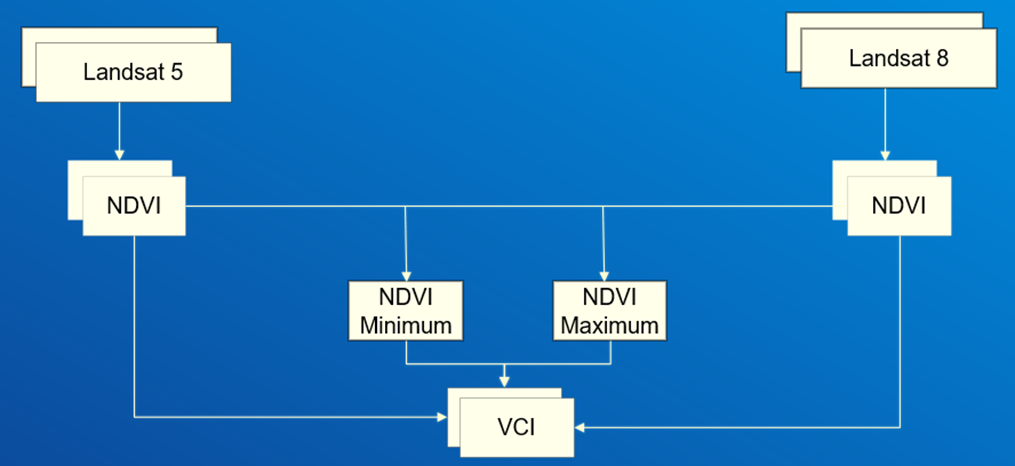

For creating training data common bands of Landsat 5 and Landsat 8 were extracted, The common bands are shown in the table below:
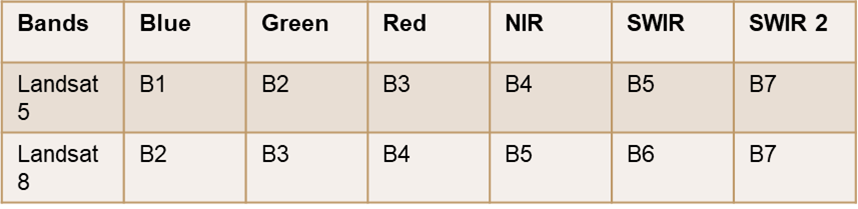

The common bands of Landsat and NDVI min & NDVI max were stacked together to create a 8 band composite raster for all the four years. The composite raster and VCI raster were used to export the training data in Export Tiles format.

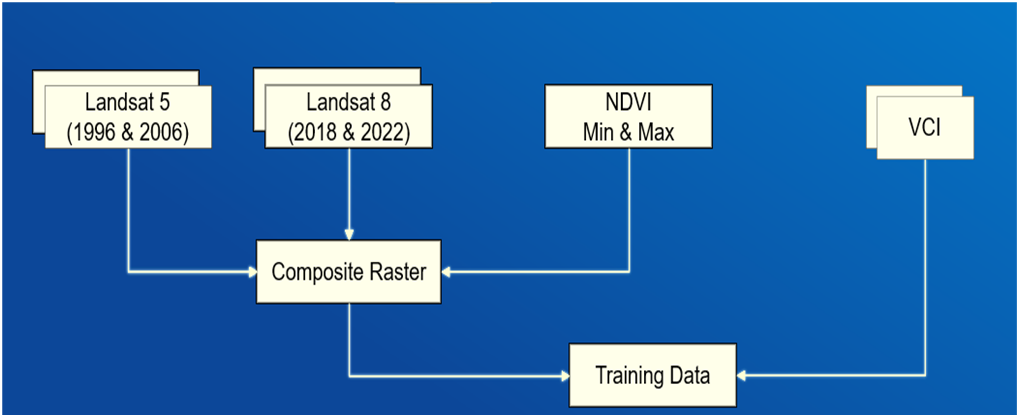

The diagram above encapsulates the overall methodology used in the estimation of the Vegetation Condition Index from multispectral imagery using deep learning.

The data will be exported in the “Export_Tiles” metadata format, which is available in the [Export Training Data For Deep Learning tool](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/export-training-data-for-deep-learning.htm). This tool is available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) and [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server). The various inputs required by the tool are described below:

- `Input Raster`: landsat_composite_raster

- `Additional Input Raster`: lst_raster

- `Tile Size X & Tile Size Y`: 256

- `Stride X & Stride Y`: 128

- `Meta Data Format`: 'Export_Tiles' (as we are training a `Pix2Pix` model).

- `Environments`: Set optimum `Cell Size`, `Processing Extent`.

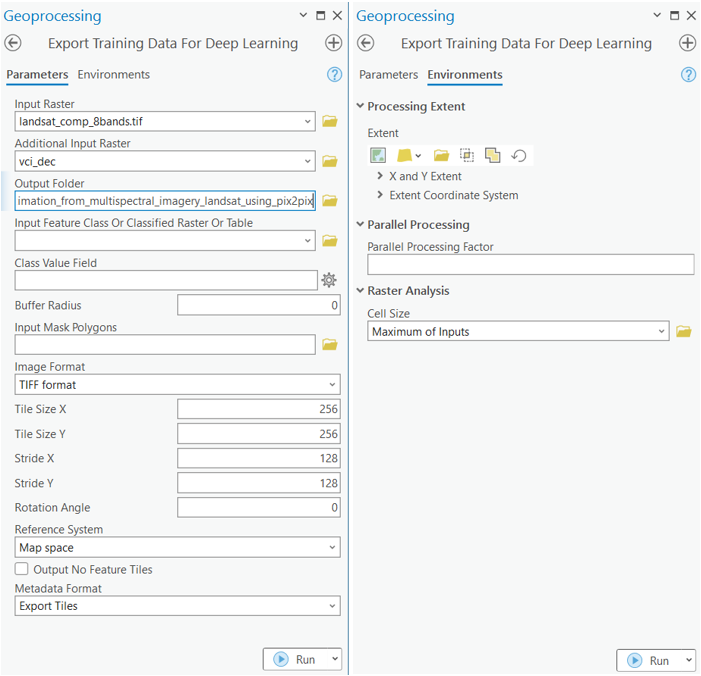

Inside the exported data folder, the 'Images' and 'Images2' folders contain all of the image tiles from the two domains exported from `landsat_comp_8bands` and `vci_dec` respectively.

## Model training

Alternatively, we have provided a subset of training data containing a few samples that follow the same directory structure mentioned above and that provides the rasters used for exporting the training dataset. This data can be used to run the experiments.

<Item title:"generating_lst_from_multispectral_imagery_using_pix2pix" type:Image Collection owner:demos_deldev>
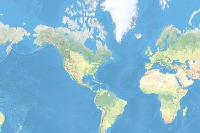

In [5]:
training_data = gis.content.get('11ebeb485c2d44898b32b91b105f8de6')
training_data

In [6]:
filepath = training_data.download(file_name=training_data.name)

In [7]:
#Extract the data from the zipped image collection
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

### Prepare data

In [8]:
output_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [3]:
data = prepare_data(output_path, dataset_type="Pix2Pix", batch_size=8)

### Visualize a few samples from your training data

To get a sense of what the training data looks like, the `arcgis.learn.show_batch()` method randomly picks a few training chips and visualizes them. Below, the images displayed on the left are Landsat-8 rasters, and the images on the right are the corresponding LST rasters.

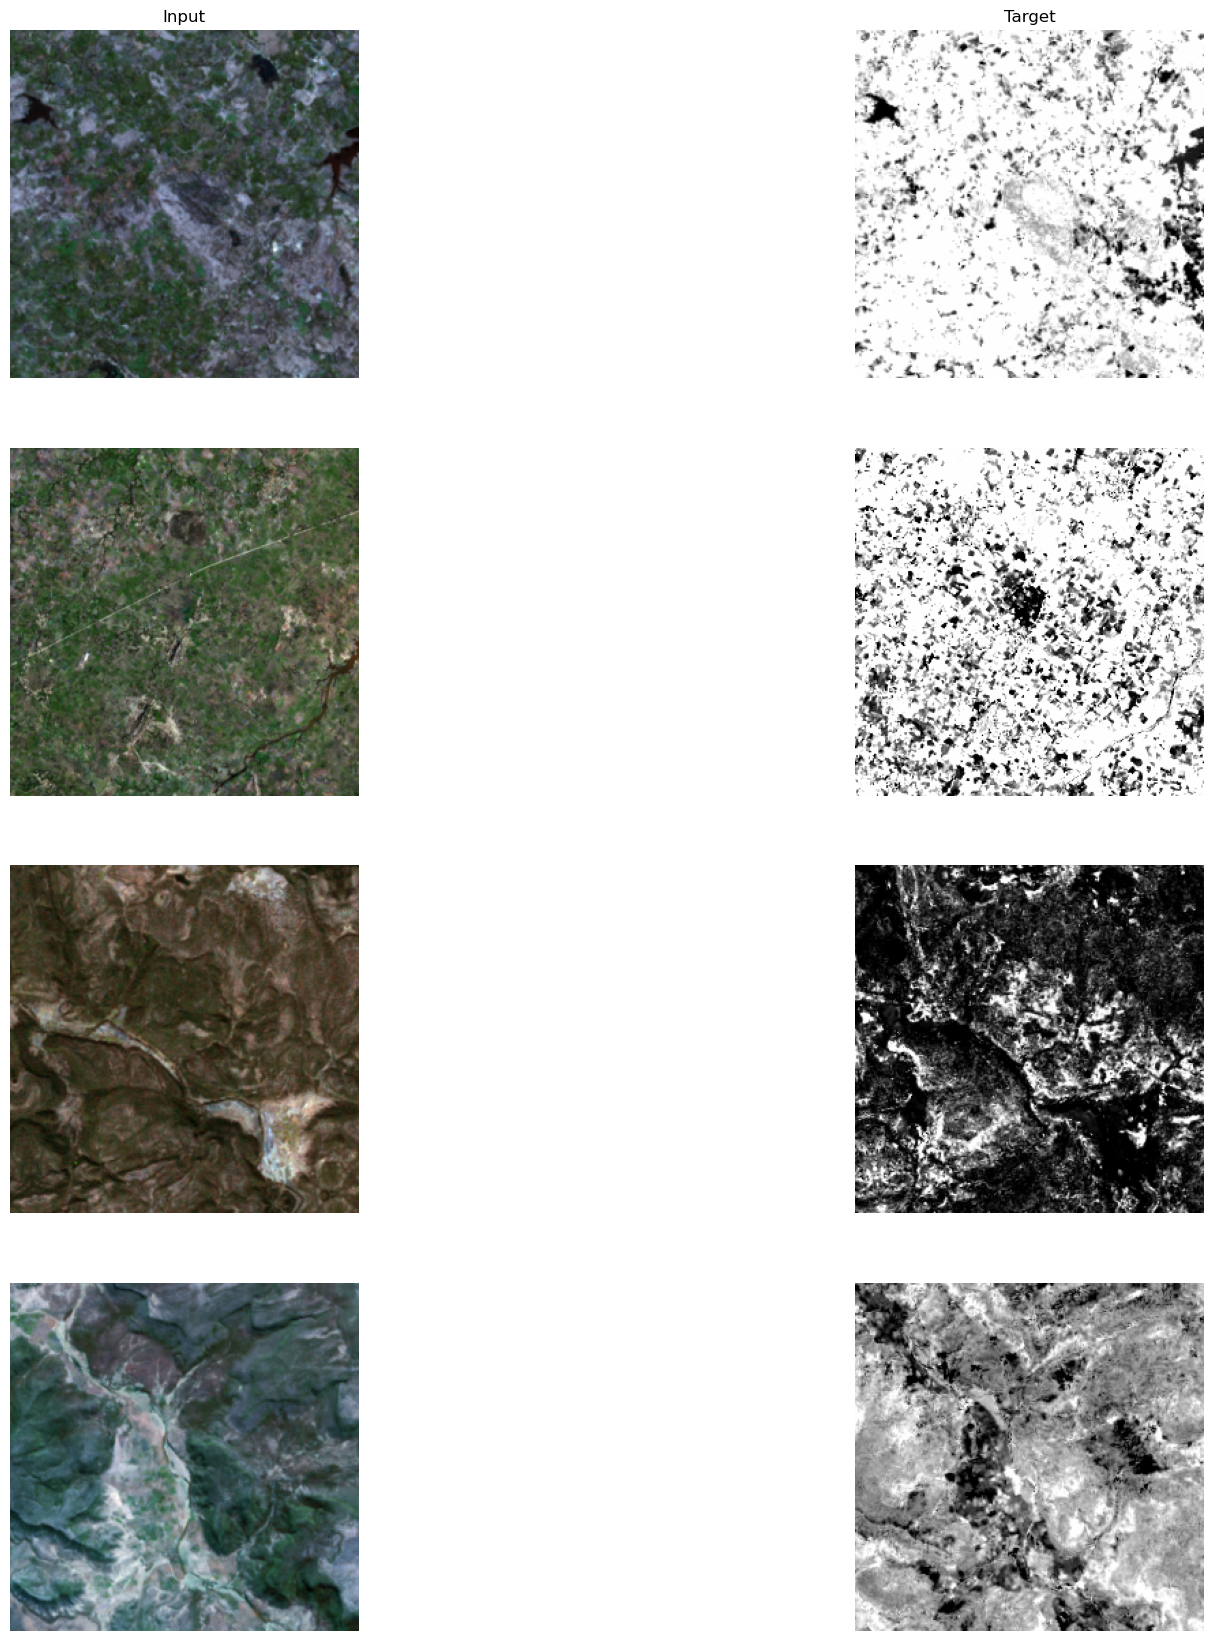

In [4]:
data.show_batch()

In [5]:
data

DataBunch;

Train: Pix2PixHDDataset(torch.Size([8, 256, 256]), torch.Size([8, 256, 256])), items_A:3676, items_B:3676;

Valid: Pix2PixHDDataset(torch.Size([8, 256, 256]), torch.Size([8, 256, 256])), items_A:408, items_B:408;

Test: None

### Load model architecture

In [6]:
model = Pix2PixHD(data)

### Tuning for optimal learning rate

Learning rate is one of the most important hyperparameters in model training. ArcGIS API for Python provides a learning rate finder that automatically chooses the optimal learning rate for you.

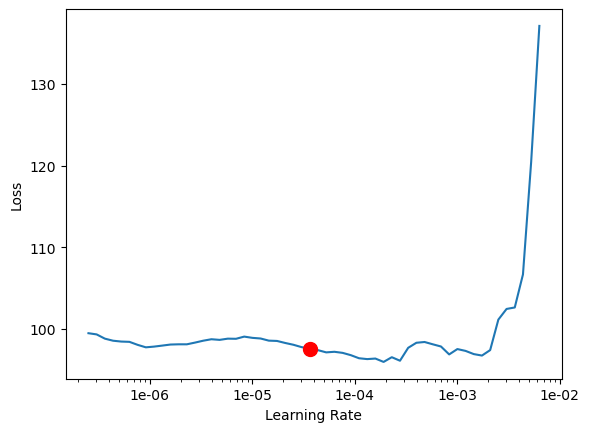

3.630780547701014e-05

In [7]:
lr = model.lr_find()
lr

### Fit the model

Next, the model is trained for 50 epochs with the suggested learning rate.

In [12]:
model.fit(50)

Here, with 50 epochs, we can see reasonable results, as both the training and validation losses have gone down considerably, indicating that the model is learning to translate between imagery domains. The model is further trained for 30 more epochs.

### Save the model

Next, we will save the trained model as a 'Deep Learning Package' ('.dlpk' format). The Deep Learning package format is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the save() method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [21]:
model.save("pix2pix_l8_model_50e")

Computing model metrics...


WindowsPath('C:/Users/shi10484/Documents/ArcGIS/Projects/agri_dec_drought/final_data/pix2pix_vci_256px_30m_u8comp_l8/models/pix2pix_l8_model_50e')

### Visualize results in validation set

It is a good practice to see the results of the model viz-a-viz the ground truth. The code below selects random samples and displays the ground truth and model predictions side by side. This enables us to preview the results of the model within the notebook.

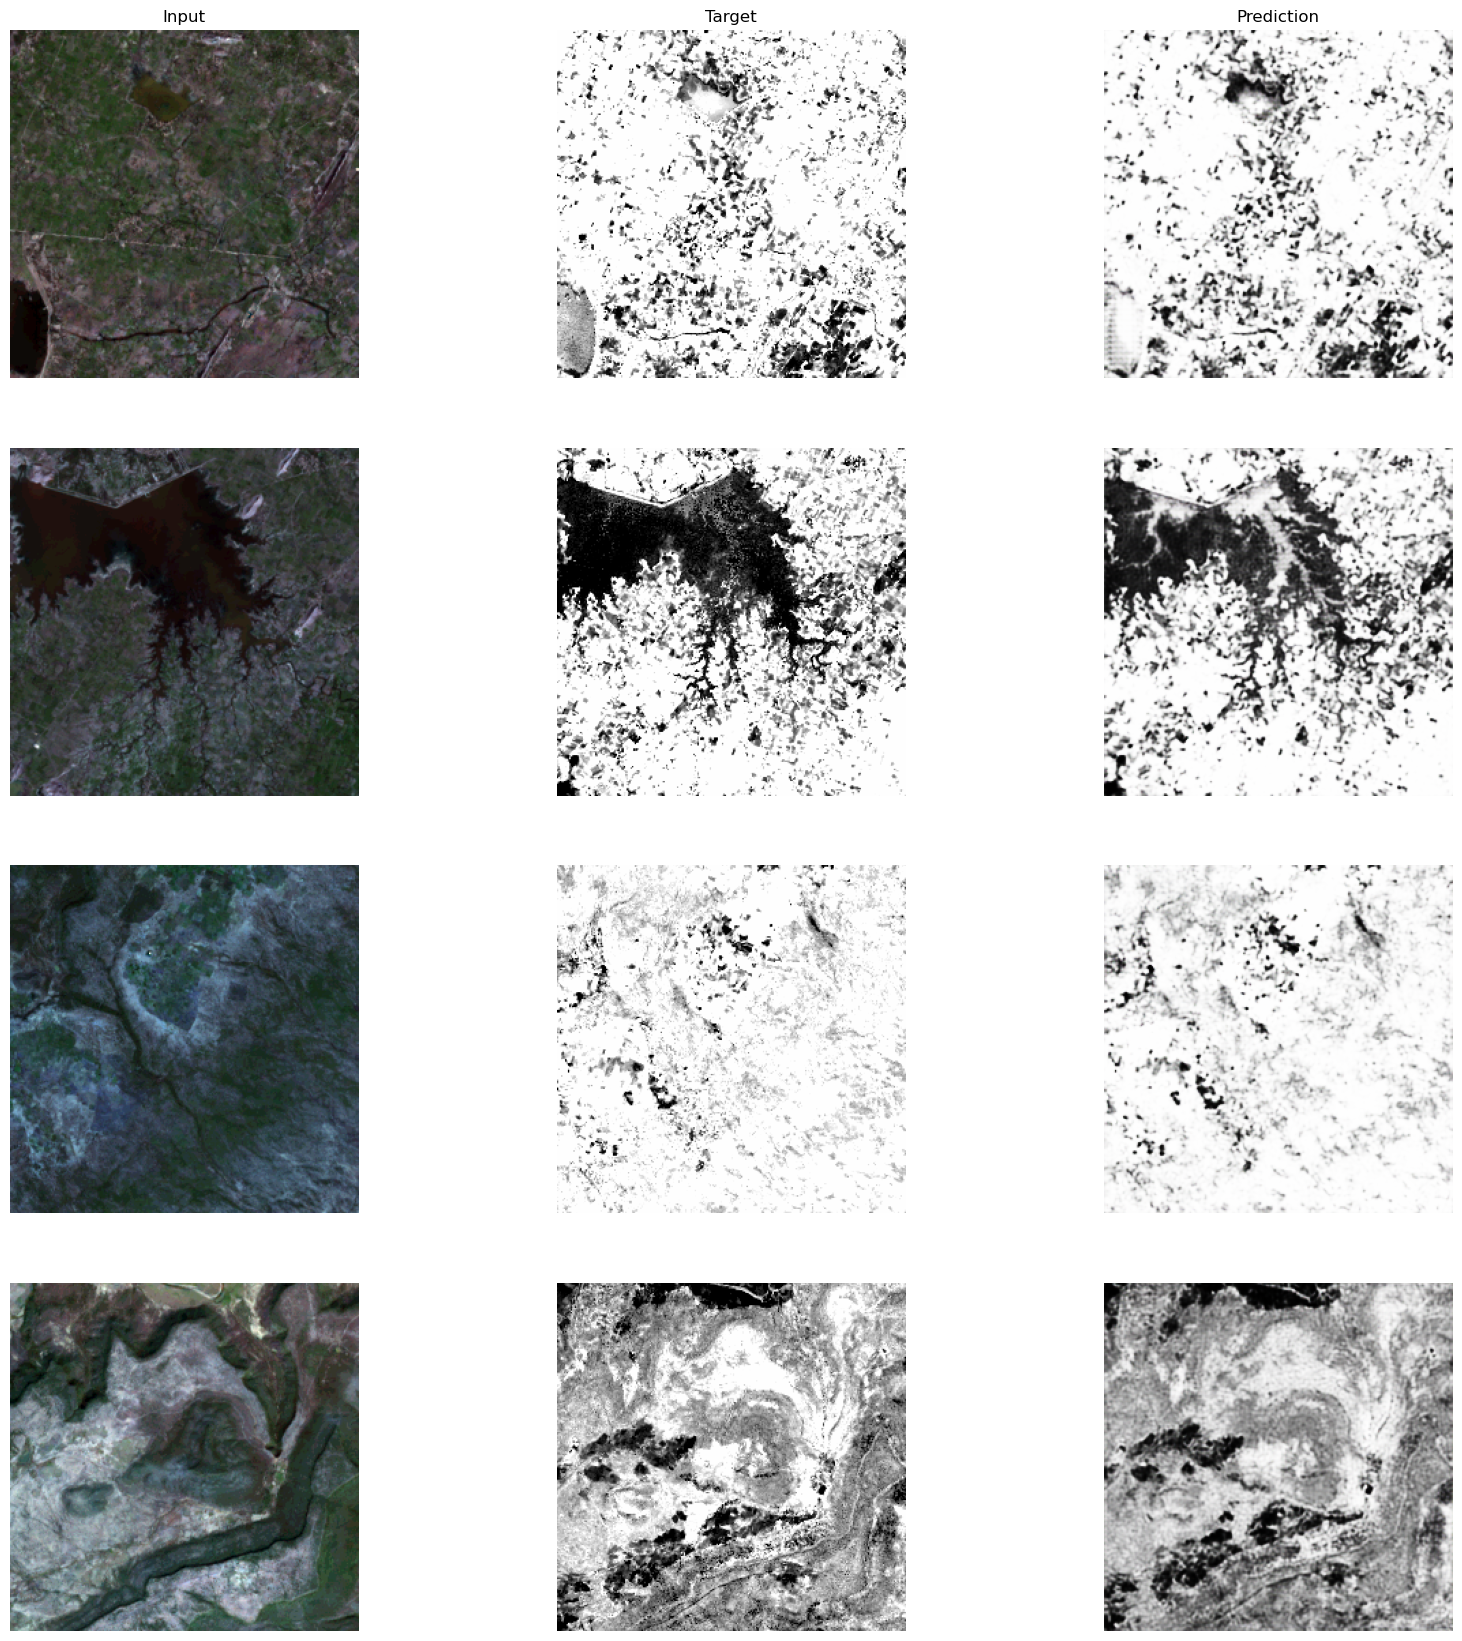

In [14]:
model.show_results(rows=4)

### Compute evaluation metrics

To objectively assess the synthesized image quality obtained from the model generators, we will quantitatively evaluate the results using the `Structural Similarity (SSIM) Index` and the `Peak Signal-to-Noise Ratio (PSNR)`.

The PSNR measures image distortion and noise level between images. The SSIM index measures the structural information similarity between images, with 0 indicating no similarity and 1 indicating complete similarity. 

In [15]:
model.compute_metrics()

{'PSNR': '8.2213e+00', 'SSIM': '6.5840e-01'}

## Model inferencing

After training the `Pix2Pix` model and saving the weights for translating images, we can use the [Classify Pixels Using Deep Learning tool](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm), available in both `ArcGIS pro` and `ArcGIS Enterprise`, for inferencing at scale.


In [17]:
model_for_inferencing = gis.content.get('a94c729d87774b5e92a25d344e25364f')
model_for_inferencing

<Item title:"pix2pix_model" type:Deep Learning Package owner:api_data_owner>

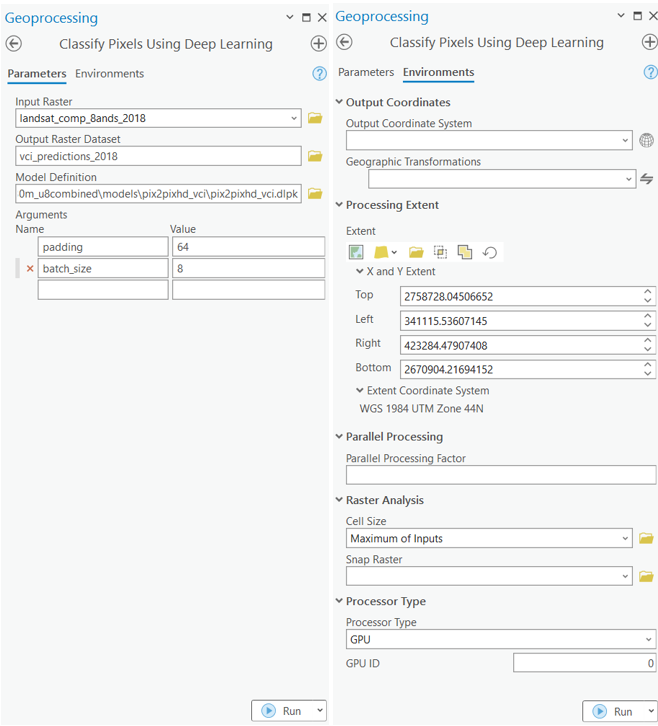

`with arcpy.EnvManager(processorType="GPU"): 
out_classified_raster = arcpy.ia.ClassifyPixelsUsingDeepLearning("composite_raster_for_inferencing", r"C:\path\to\model.dlpk", "padding 64;batch_size 8", "PROCESS_AS_MOSAICKED_IMAGE", None); out_classified_raster.save(r"C:\sample\sample.gdb\predicted_vci
")`

### Results visualization<a class="anchor" id="1"></a>

Here, the LST for the months of April and July are generated using ArcGIS Pro. The output rasters are then published on our portal for visualization. 

<Item title:"apr_lst_ras" type:Imagery Layer owner:demos_deldev>
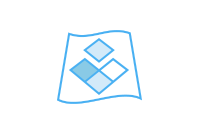

In [18]:
inferenced_results_april = gis.content.get('b52f79a31c994dc0ac30aec41733e564')
inferenced_results_april

In [19]:
from arcgis.raster.functions import colormap, stretch
inf_apr_lyr = inferenced_results_april.layers[0]
stretch_rs_apr = colormap(stretch(inf_apr_lyr, 
                                  stretch_type='PercentClip', 
                                  min=0, 
                                  max=255),
                          colormap_name="Condition Number")

<Item title:"july_lst_ras" type:Imagery Layer owner:demos_deldev>
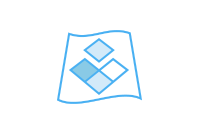

In [20]:
inferenced_results_july = gis.content.get('d02bc8947de64aee9a448a215a70bc94')
inferenced_results_july

### Results

The predictions are provided as a map for better visualization.

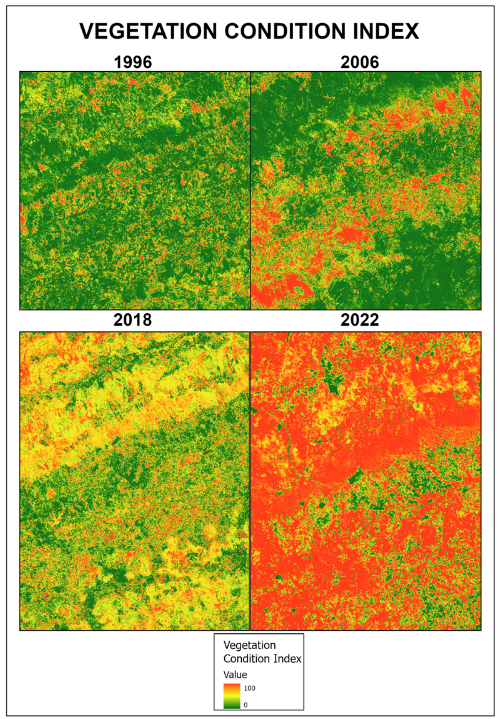

In the maps above, the Vegetation Condition Index increases from dark green to red. 1996 was a year with normal rainfall which means the vegetation has enough water to sustain and in the map it can be seen that most of the pixels are in green colour representing good vegetation condition.Whereas, 2022 year was a rain deficit year which means the vegetation stress, in the map allmost all pixels represents extremely unfavourable conditions for vegetation growth.

## Conclusion

In this notebook, we have demonstrated how to use a `Pix2Pix` model using `ArcGIS API for Python` to translate imagery from one domain to another. It is also shown that the deep learning model can be trained on different satellites to increase the temporal coverage of the trained deep learning model. The model trained in the notebook works on both Landsat-5 & Landsat-8 imagery covering approximately 30 years.